## HoVer-Net inferece로 WSI json 파일 생성 후

1. Tumor Mask - png 파일 생성 
    - json 파일에서 cetriod 중심으로 반지름이 25인 원 
2. 최종 Mask - tiff 파일 생성
    - Nerve Segmentation과의 union($\cap$) 구하기 
3. Evaluation 평가지표로 성능 파악

### 1. Tumor Mask - png 파일 생성 

In [1]:
import os
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()

In [2]:
import cv2
import openslide
import numpy     as np
from tqdm        import tqdm

In [3]:
json_path_pt5 = '/home/centos/docker/data/hovernet_inference/WSI_output/train_pan_5/Pan_PNI2021chall_train_0005/nuclei_dict.json'

with open(json_path_pt5, 'r') as f:
    line_pt5 = f.readline()
    print(len(line_pt5))

1021506010


In [4]:
svs_path_pt5 = '/home/centos/docker/data/hovernet_inference/WSI_input/train_pan_5/Pan_PNI2021chall_train_0005.svs'

radius = 25
    
WSI_img = openslide.OpenSlide(svs_path_pt5)
dims_level_0 = WSI_img.level_dimensions[0]
mask_h = WSI_img.level_dimensions[0][1]
mask_w = WSI_img.level_dimensions[0][0]
mask = np.zeros((mask_h, mask_w))

with open(json_path_pt5, 'r') as f:
    line = f.readline()
    num = line.count('centroid')
    sample = line.split(': {"centroid": ')
    for i in tqdm(range(num+1)):
        if (sample[i].rfind('"type": 1') != -1):
            cell = [int(sample[i].split(',')[0][1:]), int(sample[i].split(',')[1][1:-1])]
            cv2.circle(mask, (cell[0], cell[1]), radius, 1, cv2.FILLED)
        else:
            pass
    cv2.imwrite('WSI_mask/' + svs_path_pt5.split('/')[-1][:-4] + '.png', mask)

100%|██████████| 1572536/1572536 [02:05<00:00, 12570.09it/s] 


### 2. 최종 Mask - tiff 파일 생성

In [5]:
import PIL
import glob
import tensorflow        as tf
import matplotlib.pyplot as plt

from PIL                                  import ImageOps
from sklearn.utils                        import shuffle
from IPython.display                      import Image, display
from tensorflow.keras.preprocessing.image import load_img, array_to_img

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
BACKBONE = 'inceptionresnetv2'
IMAGE_SIZE=512
CHANNEL=3
n_classes=1
activation='sigmoid'
from model import *
clf_mdl = build_clf_model(n_classes)
seg_mdl = build_seg_model()

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [7]:
clf_mdl.load_weights('../pathology/data/model/clf_0706.hdf5')
seg_mdl.load_weights('../pathology/data/model/seg_nerve_0721_inceptionresnetv2.hdf5')

In [8]:
from util import processor
init_params = {
        'svs_path':'../../data/test_paip/pan/Pan_PNI2021chall_test_0014.svs',
        #'svs_path':'../../data/paip/col/Col_PNI2021chall_train_0017.svs',
        'xml_path':'../../new_data/paip/col/Col_PNI2021chall_train_0001.xml',
        'level':2,
        'overlap':0,
        'patch_size':512,
        'patch_dir':'./Trial'     
}

In [9]:
init_params['svs_path'] = '../../data/paip/pan/Pan_PNI2021chall_train_0005.svs'
init_params['xml_path'] = '../../data/paip/pan/Pan_PNI2021chall_train_0005.xml'

In [10]:
save_path = './test_WSI_inference/'+init_params['svs_path'].split('/')[-1][:-4]+'.tiff'
slide = processor(init_params)
tissue_mask = slide.get_tissue_mask()
mask = np.zeros((slide.dest_h,slide.dest_w))
counter = np.zeros_like(mask)
tissue_mask = cv2.morphologyEx(tissue_mask,cv2.MORPH_OPEN,cv2.getStructuringElement(cv2.MORPH_RECT,(5,5)),iterations=1)
anno_mask = slide.get_anno_mask()
min_y , min_x = slide.arr.shape[:2]
max_x , max_y = (0,0)
coord = np.where(tissue_mask>0)
if np.min(coord[1])<min_x: min_x = np.min(coord[1])
if np.max(coord[1])>max_x: max_x = np.max(coord[1])
if np.min(coord[0])<min_y: min_y = np.min(coord[0])
if np.max(coord[0])>max_y: max_y = np.max(coord[0])

slide_w = max_x-min_x; slide_h = max_y-min_y; step = 1; multiple = slide.src_h//slide.dest_h
patch_size = 512; patch_size_lv0 = 2*patch_size;  patch_size_lv2 = patch_size_lv0//multiple
s = int(patch_size_lv0*step)
y_seq,x_seq = slide.get_seq_range(slide_w,slide_h,multiple,patch_size_lv0,s)

  0%|          | 0/44 [00:00<?, ?it/s]

100%|██████████| 44/44 [04:50<00:00,  6.59s/it]


True

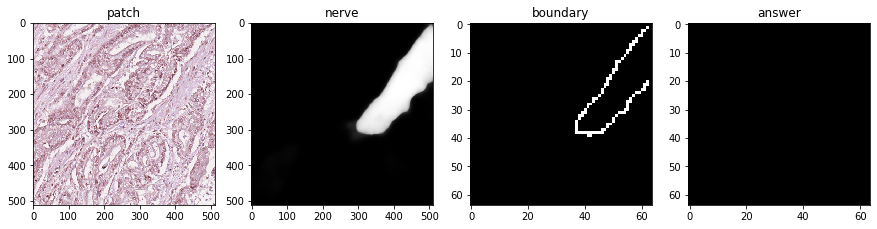

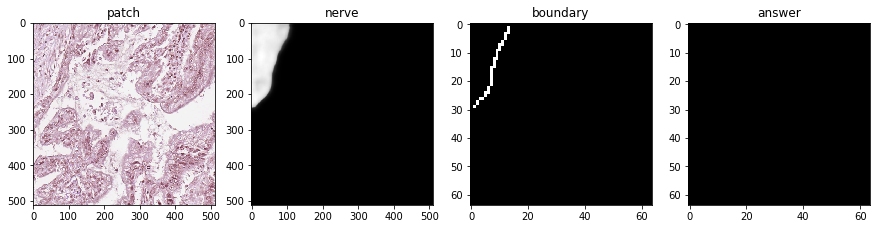

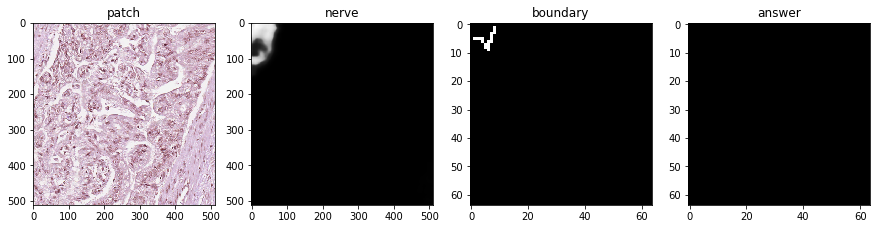

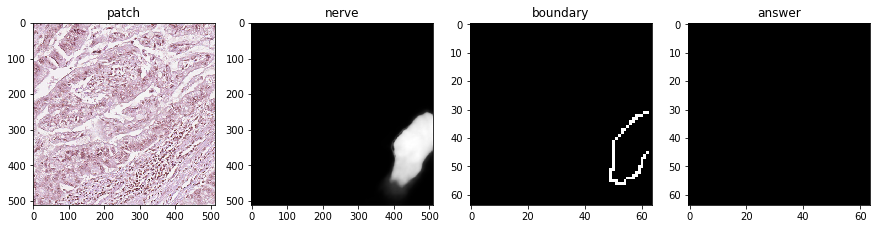

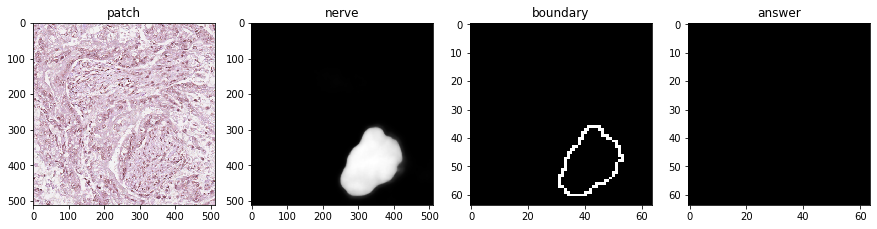

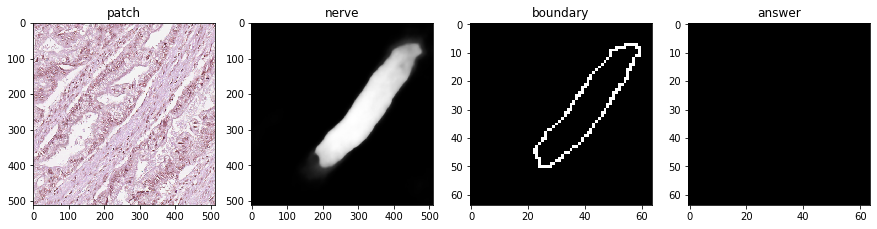

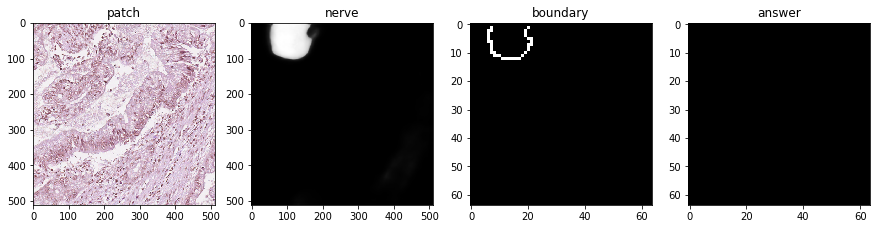

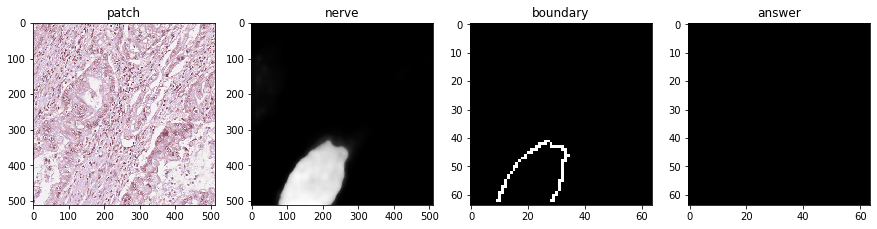

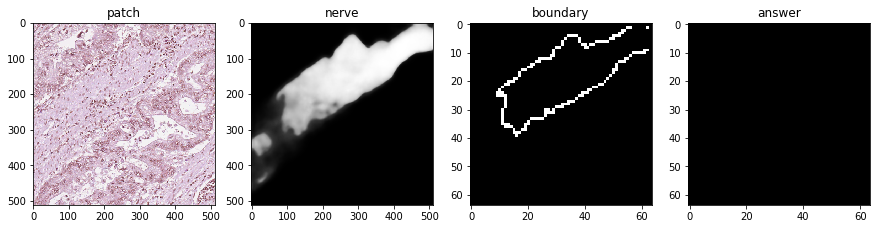

In [11]:
mask = np.zeros((slide.dest_h,slide.dest_w))
for y in y_seq:
    for x in x_seq:
        start_x = int(min_x+(s*x/multiple)); end_x = int(min_x+((s*(x+int(1/step)))/multiple))
        start_y = int(min_y+(s*y/multiple)); end_y = int(min_y+((s*(y+int(1/step)))/multiple))        
        img_patch = np.array(slide.slide.read_region(
            location=(int((min_x*multiple)+(s*x)),
                      int((min_y*multiple)+(s*y))),
            level=0, size = (patch_size_lv0,patch_size_lv0)   
        )).astype(np.uint8)[...,:3]
        img_patch_resized = cv2.resize(img_patch,(IMAGE_SIZE,IMAGE_SIZE),cv2.INTER_CUBIC)
        img_patch_rgb = cv2.cvtColor(img_patch_resized,cv2.COLOR_BGR2RGB)
        # clf 
        patch_input = np.expand_dims(img_patch_rgb,axis=0)
        patch_label = clf_mdl.predict(patch_input.astype(np.float32)/255.0)
        perineural = anno_mask['p_2'][start_y:end_y,start_x:end_x]
#         print(pred_patch)
        if patch_label>0.5:
            pred_mask = np.squeeze(seg_mdl.predict(patch_input/255.0))
            pred_mask_filter = np.where(pred_mask>0.5,255,0)
            cnts = cv2.findContours(pred_mask_filter.astype(np.uint8), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
            if len(cnts)>0:
#                 print(x,y)
                plt.figure(figsize = (15,10))
                plt.subplot(1,4,1); plt.title('patch'); plt.imshow(img_patch_rgb, cmap='gray')
                plt.subplot(1,4,2); plt.title('nerve'); plt.imshow(pred_mask, cmap='gray')
                for c in cnts:
                    pred_mask = cv2.drawContours(np.zeros((end_x-start_x,end_y-start_y)),[c//8],-1,255,1)
                pred_mask[0,:] = 0; pred_mask[-1,:] = 0; pred_mask[:,0] = 0 ; pred_mask[:,-1] = 0
                plt.subplot(1,4,3); plt.title('boundary') ;plt.imshow(pred_mask, cmap='gray')
                plt.subplot(1,4,4); plt.title('answer'); plt.imshow(perineural, cmap='gray')
            else:
                pred_mask = np.zeros((end_y-start_y,end_x-start_x))

        else:
            pred_mask = np.zeros((end_y-start_y,end_x-start_x))
        try:
            #mask[start_y:end_y,start_x:end_x] = cv.resize(pred_mask,(end_x-start_x,end_y-start_y),cv.INTER_CUBIC)
            mask[start_y:end_y,start_x:end_x] = pred_mask
        except:
            mask[start_y:end_y,start_x:end_x] = 0
cv2.imwrite(save_path,mask.astype(np.uint8))

In [12]:
save_path = './test_WSI_inference/'+init_params['svs_path'].split('/')[-1][:-4]+'_hovernet'+'.tiff'
slide = processor(init_params)
tissue_mask = slide.get_tissue_mask()
mask = np.zeros((slide.dest_h,slide.dest_w))
counter = np.zeros_like(mask)
tissue_mask = cv2.morphologyEx(tissue_mask,cv2.MORPH_OPEN,cv2.getStructuringElement(cv2.MORPH_RECT,(5,5)),iterations=1)
anno_mask = slide.get_anno_mask()
min_y , min_x = slide.arr.shape[:2]
max_x , max_y = (0,0)
coord = np.where(tissue_mask>0)
if np.min(coord[1])<min_x: min_x = np.min(coord[1])
if np.max(coord[1])>max_x: max_x = np.max(coord[1])
if np.min(coord[0])<min_y: min_y = np.min(coord[0])
if np.max(coord[0])>max_y: max_y = np.max(coord[0])

slide_w = max_x-min_x; slide_h = max_y-min_y; step = 1; multiple = slide.src_h//slide.dest_h
patch_size = 512; patch_size_lv0 = 2*patch_size;  patch_size_lv2 = patch_size_lv0//multiple
s = int(patch_size_lv0*step)
y_seq,x_seq = slide.get_seq_range(slide_w,slide_h,multiple,patch_size_lv0,s)

  0%|          | 0/44 [00:00<?, ?it/s]

In [13]:
mask_col = cv2.imread('WSI_mask/Pan_PNI2021chall_train_0005.png', 0)

100%|██████████| 44/44 [05:28<00:00,  7.47s/it]


True

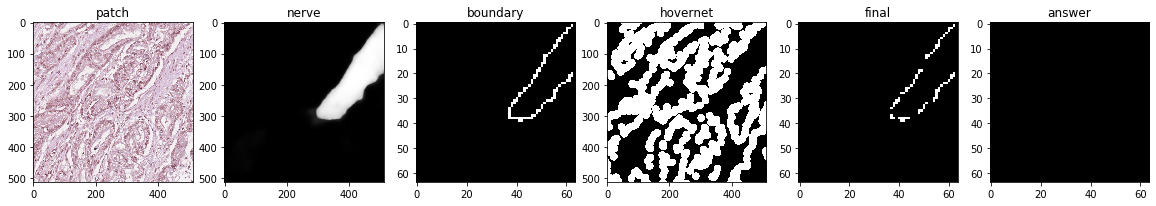

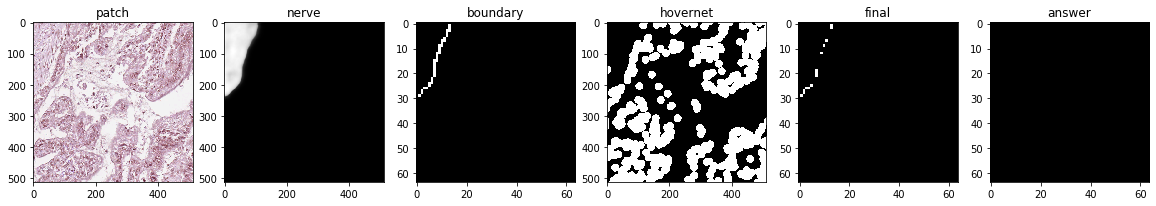

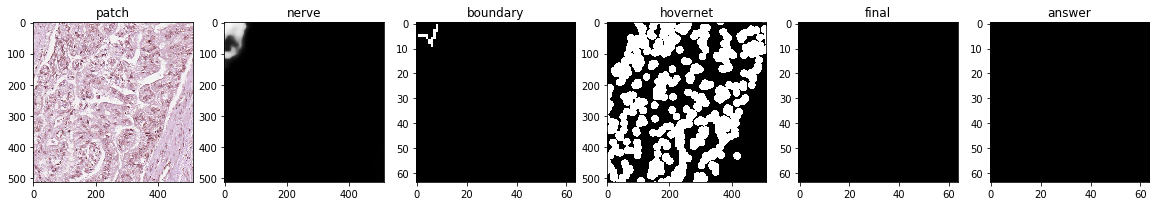

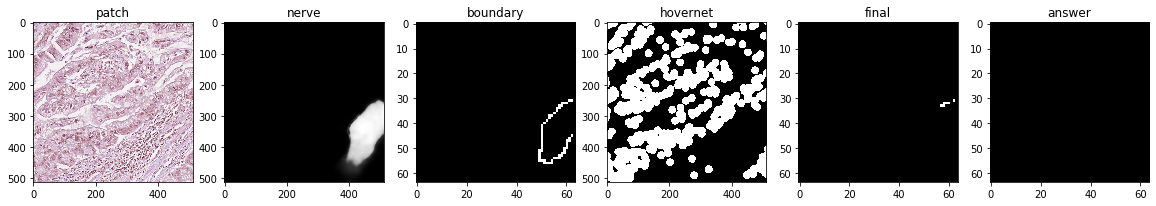

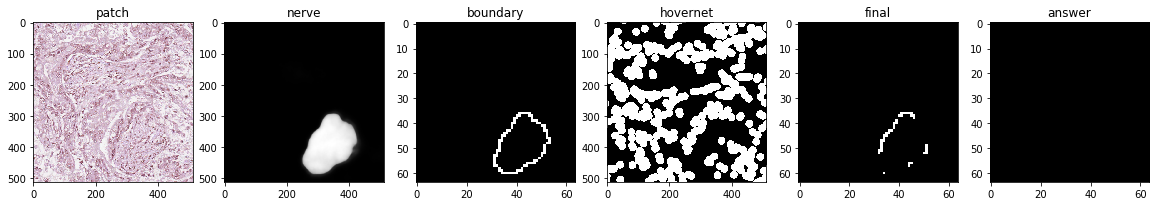

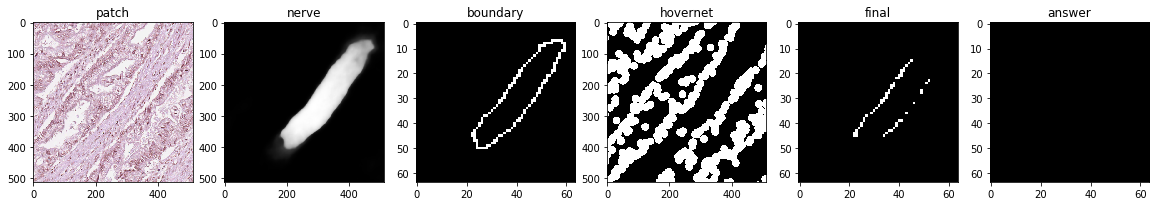

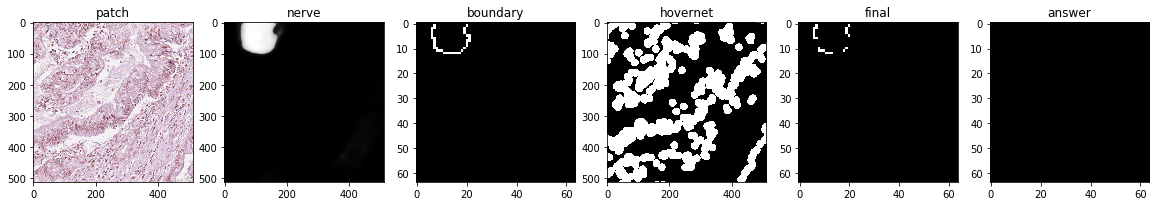

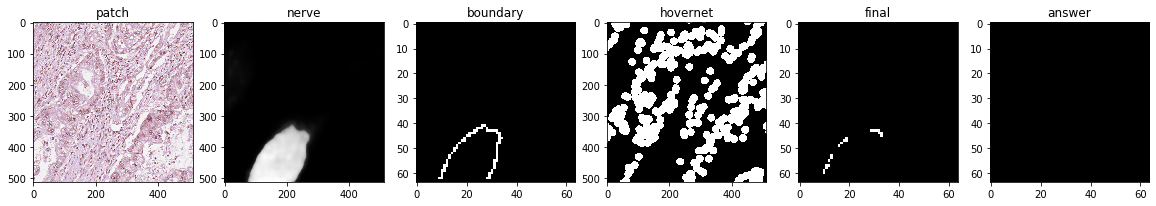

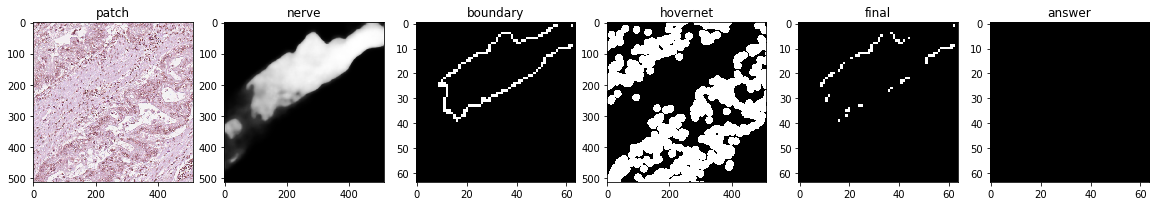

In [14]:
mask = np.zeros((slide.dest_h,slide.dest_w))
for y in y_seq:
    for x in x_seq:
        start_x = int(min_x+(s*x/multiple)); end_x = int(min_x+((s*(x+int(1/step)))/multiple))
        start_y = int(min_y+(s*y/multiple)); end_y = int(min_y+((s*(y+int(1/step)))/multiple))        
        img_patch = np.array(slide.slide.read_region(
            location=(int((min_x*multiple)+(s*x)),
                      int((min_y*multiple)+(s*y))),
            level=0, size = (patch_size_lv0,patch_size_lv0)   
        )).astype(np.uint8)[...,:3]
        img_patch_resized = cv2.resize(img_patch,(IMAGE_SIZE,IMAGE_SIZE),cv2.INTER_CUBIC)
        img_patch_rgb = cv2.cvtColor(img_patch_resized,cv2.COLOR_BGR2RGB)
        # hovernet
        mask_col_patch = mask_col[start_y*multiple:end_y*multiple,start_x*multiple:end_x*multiple]
        mask_col_resize = cv2.resize(mask_col_patch,(IMAGE_SIZE,IMAGE_SIZE),cv2.INTER_CUBIC)
        # clf 
        patch_input = np.expand_dims(img_patch_rgb,axis=0)
        patch_label = clf_mdl.predict(patch_input.astype(np.float32)/255.0)
        perineural = anno_mask['p_2'][start_y:end_y,start_x:end_x]
#         print(pred_patch)
        if patch_label>0.5:
            pred_mask = np.squeeze(seg_mdl.predict(patch_input/255.0))
            pred_mask_filter = np.where(pred_mask>0.5,255,0)
            cnts = cv2.findContours(pred_mask_filter.astype(np.uint8), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
            if len(cnts)>0:
#                 print(x,y)
                plt.figure(figsize = (20,10))
                plt.subplot(1,6,1); plt.title('patch'); plt.imshow(img_patch_rgb, cmap='gray')
                plt.subplot(1,6,2); plt.title('nerve'); plt.imshow(pred_mask, cmap='gray')
                for c in cnts:
                    pred_mask = cv2.drawContours(np.zeros((end_x-start_x,end_y-start_y)),[c//8],-1,255,1)
                pred_mask[0,:] = 0; pred_mask[-1,:] = 0; pred_mask[:,0] = 0 ; pred_mask[:,-1] = 0
                plt.subplot(1,6,3); plt.title('boundary') ;plt.imshow(pred_mask, cmap='gray')
                plt.subplot(1,6,4); plt.title('hovernet') ;plt.imshow(mask_col_resize, cmap='gray')
                re_mask_col_resize = cv2.resize(mask_col_resize, (pred_mask.shape[0],pred_mask.shape[1]), cv2.INTER_CUBIC)
                final = np.logical_and(pred_mask, re_mask_col_resize)
                plt.subplot(1,6,5); plt.title('final') ;plt.imshow(final, cmap='gray')
                plt.subplot(1,6,6); plt.title('answer'); plt.imshow(perineural, cmap='gray')
            else:
                final = np.zeros((end_y-start_y,end_x-start_x))

        else:
            final = np.zeros((end_y-start_y,end_x-start_x))
        try:
            mask[start_y:end_y,start_x:end_x] = final
        except:
            mask[start_y:end_y,start_x:end_x] = 0
cv2.imwrite(save_path,mask.astype(np.uint8))

### 3. Evaluation 평가지표로 성능 파악

In [15]:
from util import processor
from cfg import *
from metric import *
import matplotlib.pyplot as plt
import cv2 as cv
import os, glob

In [16]:
def slide_f1_score(slide_path,anno_path,tif_path):
    pr = cv.imread(tif_path,0)
    #pr = (pr.astype(np.float32)/255.0).astype(np.uint8)
    pr = pr.astype(np.uint8)
    init_params.update({
        'svs_path':slide_path,
        'xml_path':anno_path
    })
    slide = processor(init_params)
    masks = slide.get_anno_mask(tool='etc')
    gt = (masks['p_2']/255.0).astype(np.uint8)
    return compute_dist_f1_score(pr,gt)

def mean_f1_score(slide_path_list,anno_path_list,tif_path_list):
    '''
    Evaluation을 할 wsi 이미지, annotation xml, tif 파일을 쌍으로 갖는 list를 입력하여 f1-score의 평균값을 반환합니다
    '''
    list_len = len(slide_path_list)
    ret = 0
    for i in range(list_len):
        slide_score=slide_f1_score(slide_path_list[i],anno_path_list[i],tif_path_list[i])
        print(slide_score)
        ret+=slide_score
    ret/= list_len
    return ret

In [17]:
svs = '../../data/paip/pan/Pan_PNI2021chall_train_0005.svs'
xml = '../../data/paip/pan/Pan_PNI2021chall_train_0005.xml'
clf_seg_tif = './test_WSI_inference/Pan_PNI2021chall_train_0005.tiff'
hovernet_tif = './test_WSI_inference/Pan_PNI2021chall_train_0005_hovernet.tiff'

In [18]:
print('clf_seg f1 score:', slide_f1_score(svs,xml,clf_seg_tif))
print('hovernet f1 score', slide_f1_score(svs,xml,hovernet_tif))

clf_seg f1 score: 0.0
hovernet f1 score 0.0
